# Background Obective

Home Credit is currently using various statistical methods and Machine Learning to make credit score predictions. Now, we ask you to unlock the maximum potential of our data. In this way, we can ensure that customers who are able to make repayment are not rejected when applying for a loan, and loans can be given with a principal, maturity, and payment calendar that will motivate customers to be successful. Evaluation will be carried out by checking how deep your understanding of the analysis you are working on is. For the record, you need to use at least 2 Machine Learning models, one of which is Logistic Regression.

# Import Libraries

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 10.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
# metrics used in classification
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

# set chart theme
sns.set_theme(style="whitegrid", palette="pastel")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [ ]:
df_credit = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/df_final.csv')
df_credit = df_credit.drop(df_credit.columns[0], axis=1)
app_credit = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_train.csv')

# Data Preprocessing

In this section, we would be wrangling the data. We would have to change the datatypes and doing feature engineering to make ML model perform better.

But before merging the dataset into one dataset, we have to take a look at those datas one by one.

In [ ]:
app_credit.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_credit.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [ ]:
# general information
app_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
# checking missing values
pd.DataFrame(app_credit.isna().sum() / len(app_credit) * 100)

,0
SK_ID_CURR,0.000000
TARGET,0.000000
NAME_CONTRACT_TYPE,0.000000
CODE_GENDER,0.000000
FLAG_OWN_CAR,0.000000
...,...
AMT_REQ_CREDIT_BUREAU_DAY,13.501631
AMT_REQ_CREDIT_BUREAU_WEEK,13.501631
AMT_REQ_CREDIT_BUREAU_MON,13.501631
AMT_REQ_CREDIT_BUREAU_QRT,13.501631


In [ ]:
# checking duplicates values
app_credit.duplicated().sum()

0

**Conclusion:**
- The data has **307510** rows and 122 columns.
- There is no duplicates values.
- There are some columns with missing values that need to be handled.

## Deleting Columns with Missing Values

In [ ]:
# getting columns with missing values
def get_missing(data, num):
  '''
  get the columns with the largest missing values
  '''
  percentage_mv = data.isna().sum() / len(data) * 100
  missing_values = []
  for i in zip(percentage_mv.index,percentage_mv.values):
      if i[1] > num: # getting column with more than 10% missing values
          missing_values.append(i[0])
  return missing_values

In [ ]:
# column with missing columns
col_missing_values = get_missing(app_credit, 10)
len(col_missing_values)

57

In [ ]:
# drop the columns with missing values
app_credit = app_credit.drop(col_missing_values, axis=1)
app_credit.shape

(307511, 65)

In [ ]:
# checking missing values
app_credit.isnull().sum().sort_values()

SK_ID_CURR                        0
HOUR_APPR_PROCESS_START           0
FLAG_DOCUMENT_20                  0
REG_REGION_NOT_WORK_REGION        0
LIVE_REGION_NOT_WORK_REGION       0
                               ... 
OBS_30_CNT_SOCIAL_CIRCLE       1021
DEF_30_CNT_SOCIAL_CIRCLE       1021
OBS_60_CNT_SOCIAL_CIRCLE       1021
DEF_60_CNT_SOCIAL_CIRCLE       1021
NAME_TYPE_SUITE                1292
Length: 65, dtype: int64

## Handling Missing Values

Because there are more tahn a thousand rows that has missing values. So, we need to impute it with some values (categorical or numerical).

In [ ]:
# get numeric columns
num_cols = [i for i in app_credit.columns if app_credit[i].isnull().any() and app_credit[i].dtypes != 'object']

# get categorical columns
obj_cols = [i for i in app_credit.columns if app_credit[i].isnull().any() and app_credit[i].dtypes == 'object']

In [ ]:
print(num_cols, obj_cols)

['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE'] ['NAME_TYPE_SUITE']


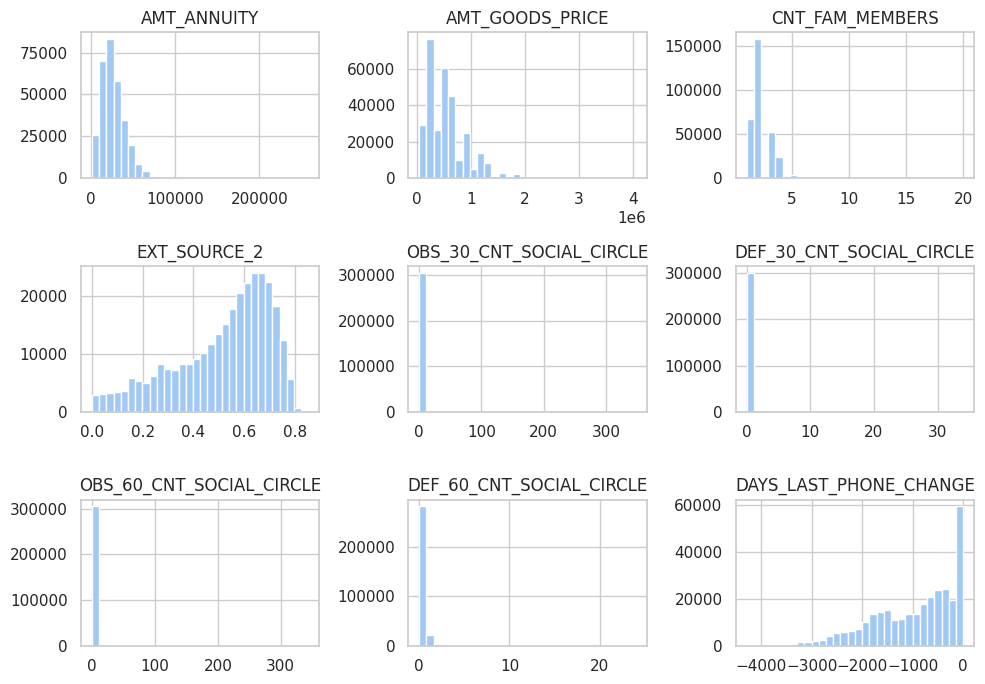

In [ ]:
# columns (numerical) distribution with missing values
fig, axs = plt.subplots(3,3,figsize=(10,7))

for i, col in enumerate(num_cols):
    axs[int(i // 3), i % 3].hist(app_credit[col], bins=30)  # Access axes using indexing
    axs[int(i // 3), i % 3].set_title(col)  # Set title

# Adjust layout (optional)
plt.tight_layout()
plt.show()

**Conclusion:**

The distribution of columns with missing values seems skewed. There must be outliers there. To overcome that, we impute the value with median value.

In [ ]:
# impute the missing values with median value
for cols in app_credit[num_cols]:
  app_credit[cols] = app_credit[cols].fillna(app_credit[cols].median())

In [ ]:
# columns (categorical) distribution with missing values
type_suite = app_credit[obj_cols].value_counts()
type_suite

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
dtype: int64

In [ ]:
# impute the missing values in categorical with mode
app_credit[obj_cols] = app_credit[obj_cols].fillna(app_credit[obj_cols].mode().loc[0][0])

In [ ]:
# check again if there is a missing value or not
app_credit.isna().sum()

SK_ID_CURR            0
TARGET                0
NAME_CONTRACT_TYPE    0
CODE_GENDER           0
FLAG_OWN_CAR          0
                     ..
FLAG_DOCUMENT_17      0
FLAG_DOCUMENT_18      0
FLAG_DOCUMENT_19      0
FLAG_DOCUMENT_20      0
FLAG_DOCUMENT_21      0
Length: 65, dtype: int64

## Deleting Unnecessary Columns (in my opinion)

Because we just analyze several columns. So, we delete several columns that for me has no meaning in analyzing user's behaviour and keeping several columns for building a model.

In [ ]:
# seeing columns
app_credit.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCI

In [ ]:
# unnecessary columns
app_credit = app_credit.drop(list(app_credit.columns[-20:]), axis=1)
app_credit.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,Business Entity Type 3,0.262949,2.0,2.0,2.0,2.0,-1134.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,School,0.622246,1.0,0.0,1.0,0.0,-828.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,Government,0.555912,0.0,0.0,0.0,0.0,-815.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,Business Entity Type 3,0.650442,2.0,0.0,2.0,0.0,-617.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,1,1,Religion,0.322738,0.0,0.0,0.0,0.0,-1106.0


# Learning The Core Parameters

In this section we will be learning about the core parameters of this dataset. Core parameter is a parameter that gives us important information about the data and helps us identify the problem.

The core parameters:
- `CODE_GENDER`
- `AMT_INCOME_TOTAL`
- `AMT_CREDIT`

What would we do:
- Checking outliers.
- Deleting outliers.
- Checking unique values.
- Replacing values.

## Code Gender

In [ ]:
app_credit['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [ ]:
app_credit.pivot_table(index='CODE_GENDER', values='SK_ID_CURR', aggfunc='count')

,SK_ID_CURR
CODE_GENDER,
F,202448
M,105059
XNA,4


As we see, there is a value called XNA. Maybe it means someone who doesn't want other people know about their gender. Because it is only 4 XNA. So, we will replace it with mode values.

In [ ]:
app_credit['CODE_GENDER'].mode()[0]

'F'

In [ ]:
app_credit['CODE_GENDER'] = app_credit['CODE_GENDER'].replace('XNA', app_credit['CODE_GENDER'].mode()[0])

In [ ]:
app_credit['CODE_GENDER'].unique()

array(['M', 'F'], dtype=object)

## Amount of Income Total

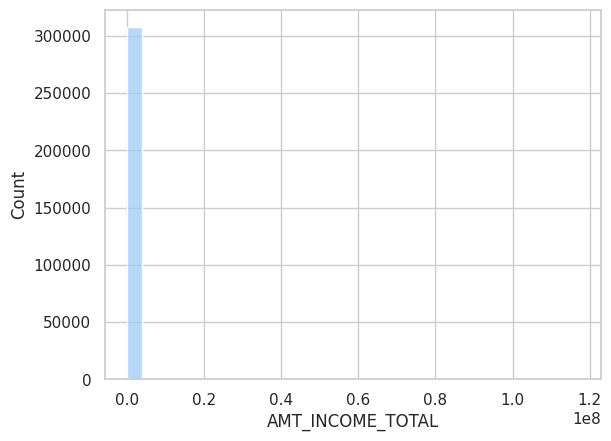

In [ ]:
# histotgram chart
sns.histplot(app_credit, x='AMT_INCOME_TOTAL', bins=30)
plt.show()

<Axes: >

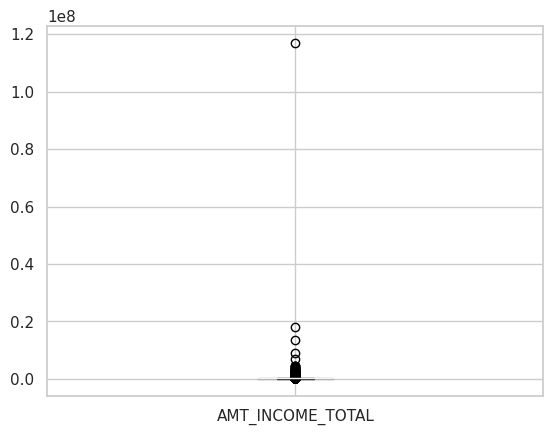

In [ ]:
# boxplot chart
app_credit.boxplot(column=['AMT_INCOME_TOTAL'])

It looks like for this columns there is a big outliers there. So we need to delete so our analysis and modeling will not be distrubed. To delete this, we are using IQR to determine the line of how many values we should delete.

In [ ]:
q1_income = app_credit['AMT_INCOME_TOTAL'].quantile(0.25)
q3_income = app_credit['AMT_INCOME_TOTAL'].quantile(0.75)
iqr_income = q3_income - q1_income

upper_limit = q3_income+(1.5*iqr_income)
lower_limit = q1_income-(1.5*iqr_income)

337500.0

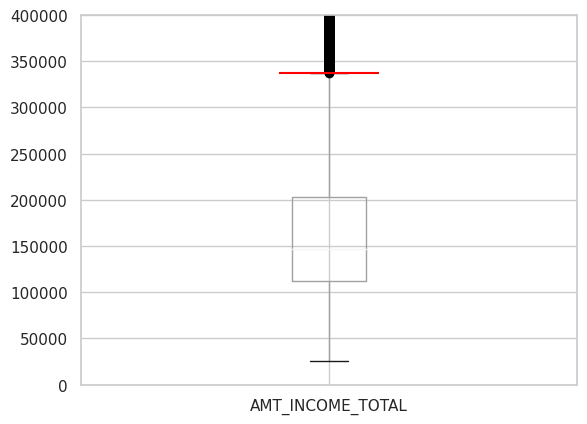

In [ ]:
plt.ylim(0, 400000)
app_credit.boxplot(column=['AMT_INCOME_TOTAL'])
plt.hlines(y=upper_limit, xmin=0.9, xmax=1.1, color='red')
upper_limit

The upper limit shows that the values stop at 337500.0. So, we are going to take the data based on the upper limit.

## Amount of Credit

<Axes: >

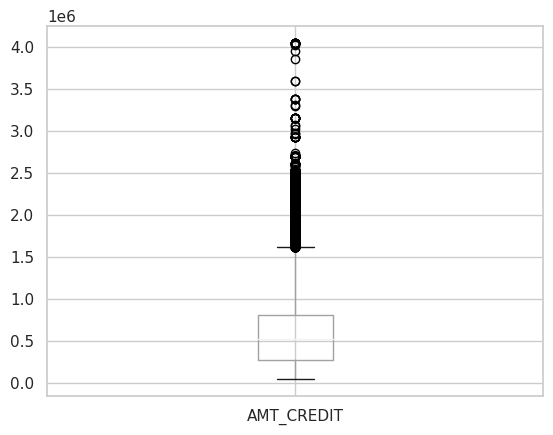

In [ ]:
# boxplot chart
app_credit.boxplot(column=['AMT_CREDIT'])

Even there is outliers, but it's not bad as amount income total. So, we keep this outlier to keep information about amount credit.

## Filtering The Dataset

In [ ]:
app_credit = app_credit.query('AMT_INCOME_TOTAL<=337500.0').reset_index(drop=True)
app_credit

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,Business Entity Type 3,0.262949,2.0,2.0,2.0,2.0,-1134.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,School,0.622246,1.0,0.0,1.0,0.0,-828.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,Government,0.555912,0.0,0.0,0.0,0.0,-815.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,Business Entity Type 3,0.650442,2.0,0.0,2.0,0.0,-617.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,1,1,Religion,0.322738,0.0,0.0,0.0,0.0,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293471,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,Services,0.681632,0.0,0.0,0.0,0.0,-273.0
293472,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,XNA,0.115992,0.0,0.0,0.0,0.0,0.0
293473,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,1,1,School,0.535722,6.0,0.0,6.0,0.0,-1909.0
293474,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,1,1,0,Business Entity Type 1,0.514163,0.0,0.0,0.0,0.0,-322.0


# EDA (Exploratory Data Analysis)

In exploring the data, we would be asking various questions that need answers in order to uncover or understand the data.

**Several Questions:**
- Number of people who are struggling to make payments and those who are not.
- Average loan amount and repayment capacity based on family status.
- Amount of credit borrowed based on assets owned.
- Do certain types of jobs experience difficulty making payments? And how much credit do they borrow?
- Do certain types of organizations experience difficulty making payments? And how much do they borrow?

## Number of people who are struggling to make payments and those who are not

                         TARGET  PERCENTAGE
No Payment Difficulties  269467    0.918191
Payment Difficulties      24009    0.081809
------------------------------------------------------------


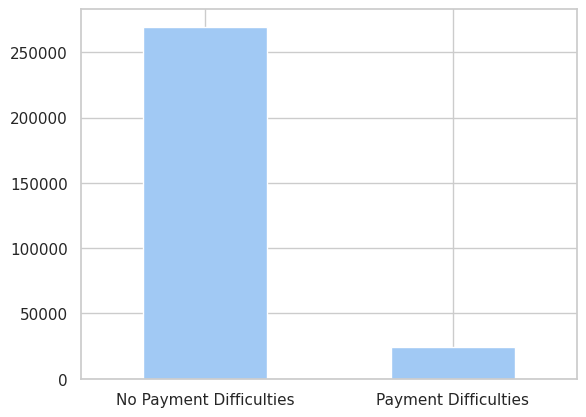

In [ ]:
num_people = app_credit.groupby(['TARGET']).agg({'TARGET':'count'})
num_people.index = ['No Payment Difficulties', 'Payment Difficulties']
num_people['PERCENTAGE'] = num_people['TARGET'] / (num_people['TARGET'][0] + num_people['TARGET'][1])
print(num_people)
print('---'*20)

# plot distribution of target
num_people['TARGET'].plot(kind='bar')
plt.xticks(rotation=0)
plt.show();

**Conclusion:**
- There were many clients who had not payment difficulties than they who did.
- Around **90%** clients who had no problem in paying the loan. Beside, around **8%** who had a problem with paying the loan.
- The data is imbalanced. So we need to take care of this before training the model.

## Average loan amount and repayment capacity based on family status

In [ ]:
# getting data about family
family_status = app_credit[['SK_ID_CURR', 'NAME_FAMILY_STATUS', 'TARGET', 'AMT_CREDIT']]
family_status

,SK_ID_CURR,NAME_FAMILY_STATUS,TARGET,AMT_CREDIT
0,100002,Single / not married,1,406597.5
1,100003,Married,0,1293502.5
2,100004,Single / not married,0,135000.0
3,100006,Civil marriage,0,312682.5
4,100007,Single / not married,0,513000.0
...,...,...,...,...
293471,456251,Separated,0,254700.0
293472,456252,Widow,0,269550.0
293473,456253,Separated,0,677664.0
293474,456254,Married,1,370107.0


In [ ]:
# groupby family to see avg credit
groupby_family = family_status.groupby(['NAME_FAMILY_STATUS'], as_index=False)['AMT_CREDIT'].mean()
groupby_family['AMT_CREDIT'] = round(groupby_family['AMT_CREDIT'], 1)

     NAME_FAMILY_STATUS  AMT_CREDIT
0        Civil marriage    523865.0
1               Married    623512.6
2             Separated    528990.6
3  Single / not married    486444.8
4               Unknown    585000.0
5                 Widow    480251.0
------------------------------------------------------------


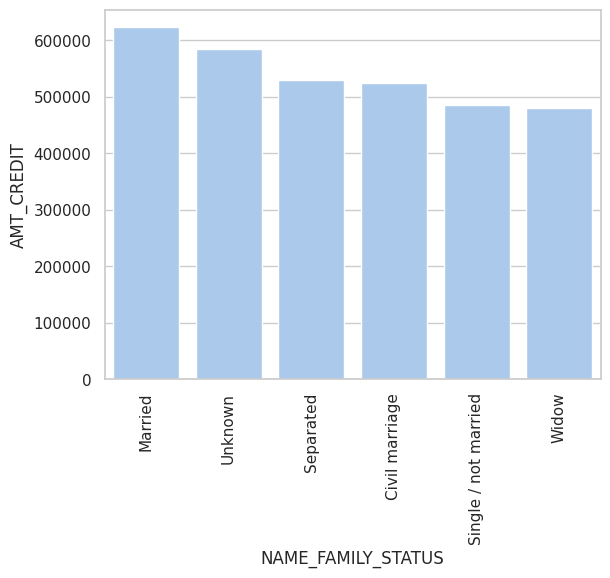

In [ ]:
print(groupby_family)
print('---'*20)
# plot family status with avg credit
sns.barplot(groupby_family.sort_values(by='AMT_CREDIT',ascending=False), x='NAME_FAMILY_STATUS', y='AMT_CREDIT')
plt.xticks(rotation=90)
plt.show();

In [ ]:
# groupby family to see the payments difficulities
groupby_family2 = family_status.groupby(['NAME_FAMILY_STATUS','TARGET'], as_index=False)['SK_ID_CURR'].count()
groupby_family2['TARGET'] = groupby_family2['TARGET'].map({0:'No Payment Difficulities',
                                                           1:'Payment Difficulities'})

      NAME_FAMILY_STATUS                    TARGET  SK_ID_CURR
0         Civil marriage  No Payment Difficulities       25687
1         Civil marriage     Payment Difficulities        2874
2                Married  No Payment Difficulities      172519
3                Married     Payment Difficulities       14337
4              Separated  No Payment Difficulities       17251
5              Separated     Payment Difficulities        1550
6   Single / not married  No Payment Difficulities       39170
7   Single / not married     Payment Difficulities        4327
8                Unknown  No Payment Difficulities           1
9                  Widow  No Payment Difficulities       14839
10                 Widow     Payment Difficulities         921
--------------------------------------------------------------------------------


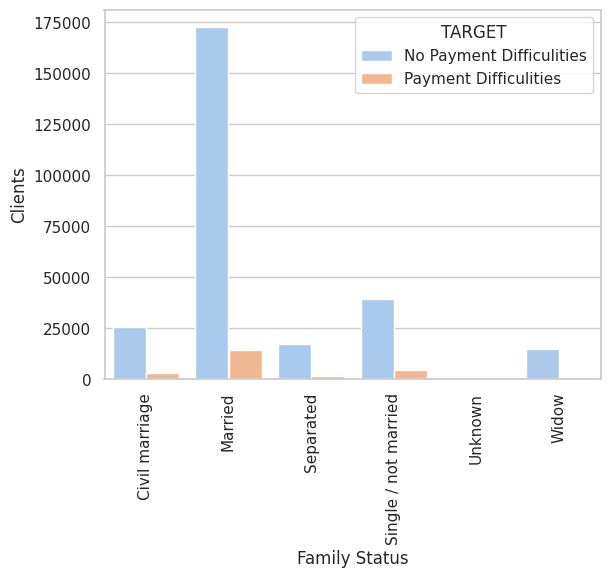

In [ ]:
print(groupby_family2)
print("----"*20)
# plot to see how many family able to pay the loan
sns.barplot(x='NAME_FAMILY_STATUS', y='SK_ID_CURR',data=groupby_family2, hue='TARGET')
plt.xlabel('Family Status')
plt.ylabel('Clients')
plt.xticks(rotation=90)
plt.show();

**Conclusion:**
- The highest average for family status is married with **623512.6** and the last is widow with **480251.0**.
- Even the married status is the highest average in amount credit but they were able to pay the loan.
- Most of the family status had no difficulities payment.

## Amount of credit borrowed based on assets owned.

In [ ]:
# taking the asset columns
col_asset = app_credit[['SK_ID_CURR','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 'FLAG_MOBIL', 'NAME_HOUSING_TYPE', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'TARGET']]
col_asset.head()

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_MOBIL,NAME_HOUSING_TYPE,NAME_CONTRACT_TYPE,AMT_CREDIT,TARGET
0,100002,N,Y,1,1,House / apartment,Cash loans,406597.5,1
1,100003,N,N,1,1,House / apartment,Cash loans,1293502.5,0
2,100004,Y,Y,1,1,House / apartment,Revolving loans,135000.0,0
3,100006,N,Y,0,1,House / apartment,Cash loans,312682.5,0
4,100007,N,Y,0,1,House / apartment,Cash loans,513000.0,0


In [ ]:
# flag own car
own_car = col_asset.groupby(['FLAG_OWN_CAR', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
own_car['TARGET'] = own_car['TARGET'].map({0:'No Payment Difficulities',
                                           1:'Payment Difficulities'})
# flag own realty
own_realty = col_asset.groupby(['FLAG_OWN_REALTY', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
own_realty['TARGET'] = own_realty['TARGET'].map({0:'No Payment Difficulities',
                                              1:'Payment Difficulities'})
# flag phone
own_phone = col_asset.groupby(['FLAG_PHONE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
own_phone['TARGET'] = own_phone['TARGET'].map({0:'No Payment Difficulities',
                                              1:'Payment Difficulities'})
own_phone['FLAG_PHONE'] = own_phone['FLAG_PHONE'].map({0:'N',
                                                       1:'Y'})
# flag mobil
own_mobil = col_asset.groupby(['FLAG_MOBIL', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
own_mobil['TARGET'] = own_mobil['TARGET'].map({0:'No Payment Difficulities',
                                              1:'Payment Difficulities'})
own_mobil['FLAG_MOBIL'] = own_mobil['FLAG_MOBIL'].map({0:'N',
                                                       1:'Y'})

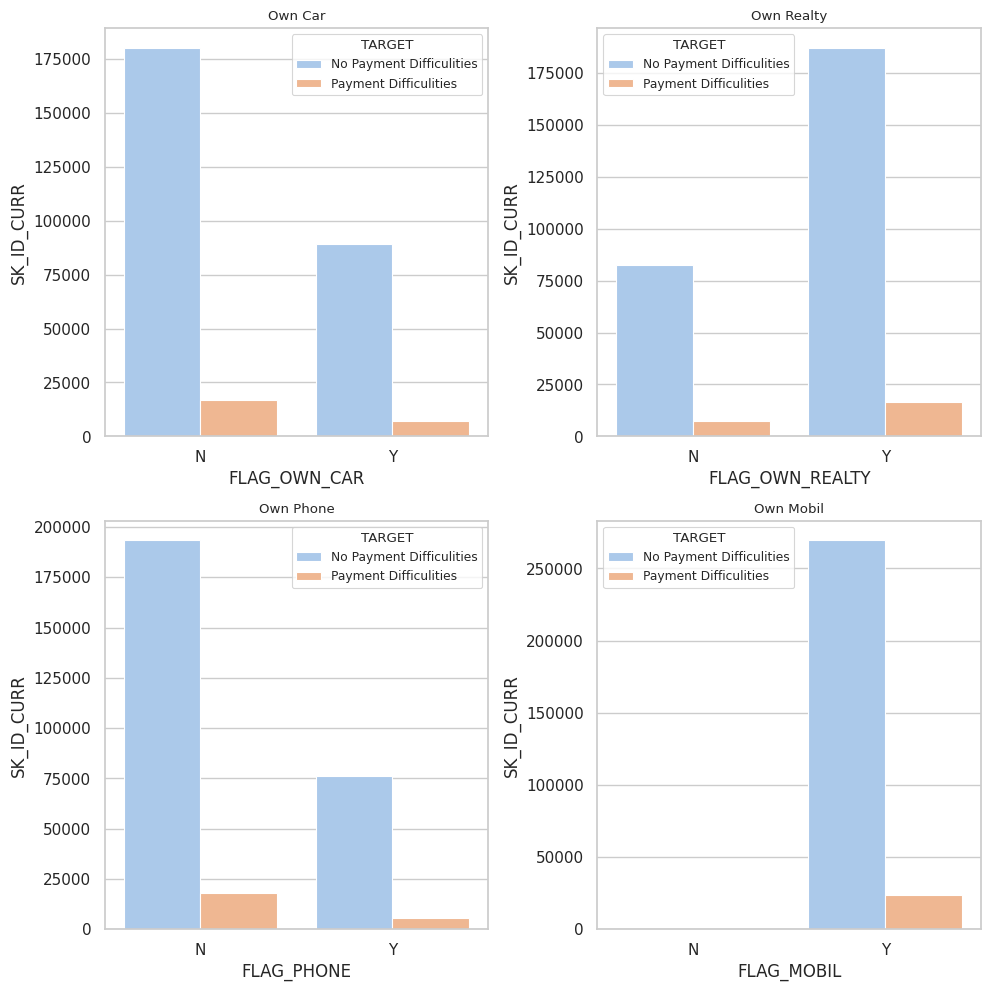

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title("Own Car")
sns.barplot(data=own_car, x='FLAG_OWN_CAR', y='SK_ID_CURR', hue='TARGET', ax=ax[0][0])

ax[0][1].set_title("Own Realty")
sns.barplot(data=own_realty, x='FLAG_OWN_REALTY', y='SK_ID_CURR', hue='TARGET', ax=ax[0][1])

ax[1][0].set_title("Own Phone")
sns.barplot(data=own_phone, x='FLAG_PHONE', y='SK_ID_CURR', hue='TARGET', ax=ax[1][0])

ax[1][1].set_title("Own Mobil")
sns.barplot(data=own_mobil, x='FLAG_MOBIL', y='SK_ID_CURR', hue='TARGET', ax=ax[1][1])

plt.tight_layout()

In [ ]:
# name housing type
house_type = col_asset.groupby(['NAME_HOUSING_TYPE'], as_index=False)['AMT_CREDIT'].mean()
house_type.sort_values('AMT_CREDIT', ascending=False)

,NAME_HOUSING_TYPE,AMT_CREDIT
3,Office apartment,599531.832921
2,Municipal apartment,585782.528043
1,House / apartment,585340.150631
0,Co-op apartment,564842.391144
4,Rented apartment,510672.786585
5,With parents,494490.275000


**Conclusion:**
- Clients who had no car, had no payment difficulities more than they who had.
- Most of the clients who had no payment difficulities, had house or place to live.
- Clients who had phone, had no payment difficulities.
- There is no clients with no phone that had payment difficulities.
- Client who live in appartment, had the highest average of amount credit loan.

## Do certain types of jobs experience difficulty making payments? And how much credit do they borrow?

In [ ]:
# take job type columns
type_jobs = app_credit[['SK_ID_CURR','NAME_INCOME_TYPE','TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']]
type_jobs.head()

,SK_ID_CURR,NAME_INCOME_TYPE,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT
0,100002,Working,1,202500.0,406597.5
1,100003,State servant,0,270000.0,1293502.5
2,100004,Working,0,67500.0,135000.0
3,100006,Working,0,135000.0,312682.5
4,100007,Working,0,121500.0,513000.0


In [ ]:
group_jobs = type_jobs.groupby(['NAME_INCOME_TYPE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
group_jobs['TARGET'] = group_jobs['TARGET'].map({0:'No Payment Difficulities',
                                                 1:'Payment Difficulities'})
group_jobs

,NAME_INCOME_TYPE,TARGET,SK_ID_CURR
0,Businessman,No Payment Difficulities,4
1,Commercial associate,No Payment Difficulities,60130
2,Commercial associate,Payment Difficulities,5009
3,Maternity leave,No Payment Difficulities,2
4,Maternity leave,Payment Difficulities,2
5,Pensioner,No Payment Difficulities,51339
6,Pensioner,Payment Difficulities,2924
7,State servant,No Payment Difficulities,19266
8,State servant,Payment Difficulities,1209
9,Student,No Payment Difficulities,17


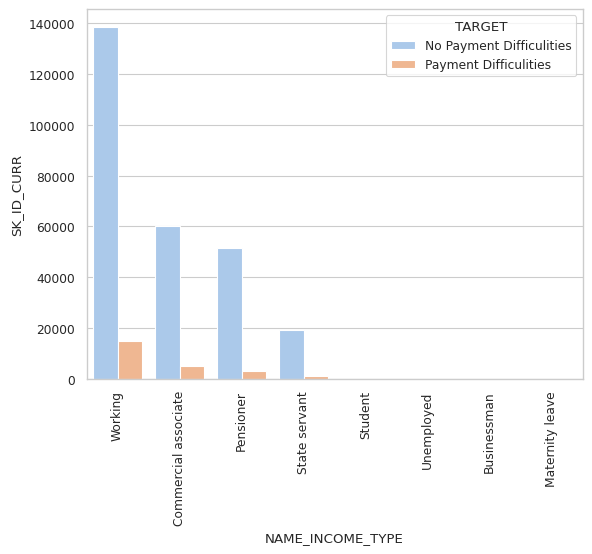

In [ ]:
# making plot
sns.barplot(data=group_jobs.sort_values('SK_ID_CURR', ascending=False), x='NAME_INCOME_TYPE', y='SK_ID_CURR', hue='TARGET')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# based on how many credit theay are loan
jobs_loan = type_jobs.groupby(['NAME_INCOME_TYPE'], as_index=False)['AMT_CREDIT'].mean()
jobs_loan['AMT_CREDIT'] = round(jobs_loan['AMT_CREDIT'],2)
# how many peopel make loan
many_people = type_jobs.groupby(['NAME_INCOME_TYPE'], as_index=False)['SK_ID_CURR'].count()
# join the information
join_jobs = jobs_loan.merge(many_people, on='NAME_INCOME_TYPE')

In [ ]:
join_jobs.sort_values('AMT_CREDIT', ascending=False)

,NAME_INCOME_TYPE,AMT_CREDIT,SK_ID_CURR
0,Businessman,911250.00,4
6,Unemployed,764386.36,22
2,Maternity leave,745875.00,4
4,State servant,647564.67,20475
1,Commercial associate,634460.78,65139
7,Working,564471.78,153552
3,Pensioner,531632.59,54263
5,Student,514363.24,17


**Conclusion:**
- Even businessman was the lowest client amount, they had the highest average in amount credit.
- Surprisingly, there were students who did borrowing the loan. But the average was low.
- The highest client's amount was working type. But, they had no payment difficulities.

## Do certain types of organizations experience difficulty making payments? And how much do they borrow?

In [ ]:
# taking the organization information
organization = app_credit[['SK_ID_CURR','TARGET', 'ORGANIZATION_TYPE', 'AMT_CREDIT']]
organization['TARGET'] = organization['TARGET'].map({0:'No Payment Difficulities',
                                                     1:'Payment Difficulities'})
organization

,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,AMT_CREDIT
0,100002,Payment Difficulities,Business Entity Type 3,406597.5
1,100003,No Payment Difficulities,School,1293502.5
2,100004,No Payment Difficulities,Government,135000.0
3,100006,No Payment Difficulities,Business Entity Type 3,312682.5
4,100007,No Payment Difficulities,Religion,513000.0
...,...,...,...,...
293471,456251,No Payment Difficulities,Services,254700.0
293472,456252,No Payment Difficulities,XNA,269550.0
293473,456253,No Payment Difficulities,School,677664.0
293474,456254,Payment Difficulities,Business Entity Type 1,370107.0


In [ ]:
group_organization = organization.groupby(['ORGANIZATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
group_organization.sort_values('SK_ID_CURR', ascending=False).head(5)

,ORGANIZATION_TYPE,SK_ID_CURR
5,Business Entity Type 3,63305
57,XNA,54275
42,Self-employed,36870
33,Other,15872
30,Medicine,10828


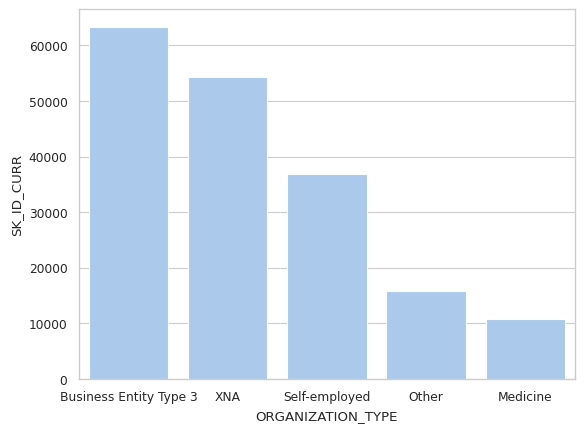

In [ ]:
sns.barplot(data=group_organization.sort_values('SK_ID_CURR', ascending=False).head(5), x='ORGANIZATION_TYPE', y='SK_ID_CURR')
plt.show()

In [ ]:
# payment ability
organization_ability = organization.groupby(['ORGANIZATION_TYPE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
organization_ability.sort_values('SK_ID_CURR', ascending=False).head(5)

,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
10,Business Entity Type 3,No Payment Difficulities,57308
114,XNA,No Payment Difficulities,51343
84,Self-employed,No Payment Difficulities,33073
66,Other,No Payment Difficulities,14638
60,Medicine,No Payment Difficulities,10108


**Conclusion:**
- Business Entity Type 3 is the highest organization that did a loan.
- Based on how many clients in every top 5 organizations, there was no one of them had payment difficulities.

# General Conclusion From EDA
After conducting EDA, the questions posed have been answered as follows:
1. There were many clients who had not payment difficulties than they who did.
2. The highest average for family status is married with 623512.6 and the last is widow with 480251.0.
3. Client who live in appartment, had the highest average of amount credit loan.
4. The highest client's amount was working type. But, they had no payment difficulities.
5. Based on how many clients in every top 5 organizations, there was no one of them had payment difficulities.

# Feature Engineering

Here, we would like to train some of machine learning models. The model that we use are: Logistic Regression, Decision Tree Classifier, and Random Forest Classifier.

Before we train our model, there are several things to do:
- Split the data into train set and test set.
- Handling the imbalanced class.
- One-hot encode and label encode for handling categorical data.
- Scaling the numerical data

In [ ]:
# deleting unimportant columns
app_credit = app_credit.drop(app_credit.columns[-6:], axis=1)
app_credit = app_credit.drop(['SK_ID_CURR', 'DAYS_ID_PUBLISH', \
                              'DAYS_REGISTRATION', 'DAYS_EMPLOYED', \
                              'REGION_POPULATION_RELATIVE', 'WEEKDAY_APPR_PROCESS_START'], axis=1)
app_credit.shape

(293476, 33)

## Split The Dataset

In [ ]:
X = app_credit.drop(['TARGET'], axis=1)
y = app_credit['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(220107, 32)
(73369, 32)
(220107,)
(73369,)


## Taking Care of Numerical and Categroical Data

In [ ]:
# copy data to label and one hot encode
X_train_labeled = X_train.copy()
X_test_labeled = X_test.copy()

# get object and numerical columns
num_cols = [col for col in X_train.columns if X[col].dtype not in ['object']]
cat_cols = [col for col in X_train.columns if X[col].dtype in ['object']]

# ordinal encode for categorical data (2 values)
# this is for LGBM model
ordinal_encode = OrdinalEncoder()
X_train_labeled[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']] = ordinal_encode.fit_transform(X_train[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']])
X_test_labeled[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']] = ordinal_encode.transform(X_test[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']])

# one hot encoding
# this is for regression model
data_ohe = pd.get_dummies(app_credit, drop_first=True)

X_ohe = data_ohe.drop('TARGET', axis=1)
y_ohe = data_ohe['TARGET']

X_train_ohe, X_test_ohe, y_ohe_train, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=0.25, random_state=42)

# scalling the numerical data
# label data
scaler = StandardScaler()
scaler.fit(X_train_labeled[num_cols])
X_train_labeled[num_cols] = scaler.transform(X_train_labeled[num_cols])
X_test_labeled[num_cols] = scaler.transform(X_test_labeled[num_cols])

# ohe data
scaler_ohe = StandardScaler()
scaler_ohe.fit(X_train_ohe[num_cols])
X_train_ohe[num_cols] = scaler_ohe.transform(X_train_ohe[num_cols])
X_test_ohe[num_cols] = scaler_ohe.transform(X_test_ohe[num_cols])

## Handling Imbalanced Data

0    0.918485
1    0.081515
Name: TARGET, dtype: float64


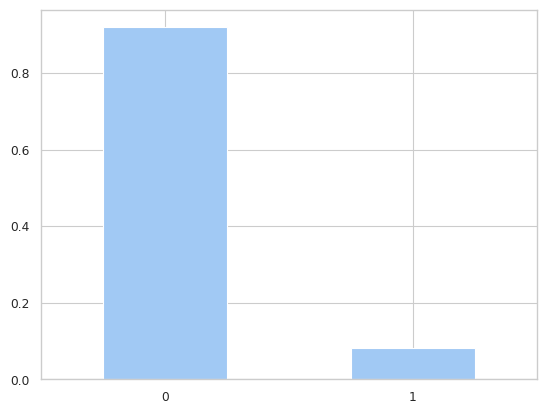

In [ ]:
print(y_train.value_counts(normalize=True))
y_train.value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# upsampling function
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

In [ ]:
# upsample for ordinal dataset
X_train_labeled_upsample, y_train_upsample = upsample(X_train_labeled, y_train, 8)

# upsample for one hot dataset
X_train_ohe_upsample, y_train_ohe_upsample = upsample(X_train_ohe, y_ohe_train, 8)

0    0.584797
1    0.415203
Name: TARGET, dtype: float64


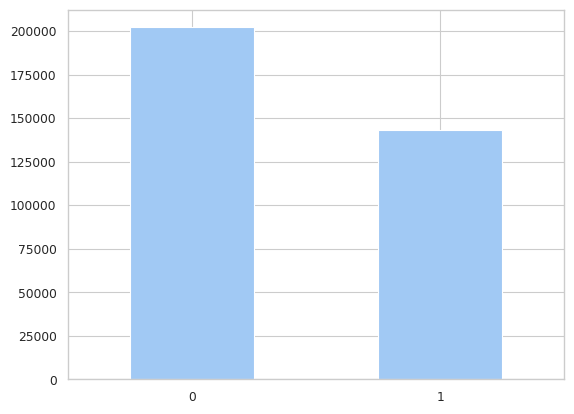

In [ ]:
# target after upsample
print(y_train_upsample.value_counts(normalize=True))
y_train_upsample.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

# Build Machine Learning Model

In [ ]:
# function to calculate model evaluation metrics
def print_model_evaluation(y_test, test_predictions):
    print("\033[1m" + 'F1 score: ' + "\033[0m", '{:.3f}'.format(f1_score(y_test, test_predictions)))
    print("\033[1m" + 'Accuracy Score: ' + "\033[0m", '{:.2%}'.format(accuracy_score(y_test, test_predictions)))
    print("\033[1m" + 'Precision: ' + "\033[0m", '{:.3f}'.format(precision_score(y_test, test_predictions)))
    print("\033[1m" + 'Recall: ' + "\033[0m", '{:.3f}'.format(recall_score(y_test, test_predictions)))
    print("\033[1m" + 'Balanced Accuracy Score: ' + "\033[0m", '{:.2%}'.format(balanced_accuracy_score(y_test, test_predictions)))
    print("\033[1m" + 'AUC-ROC Score: ' + "\033[0m", '{:.2%}'.format(roc_auc_score(y_test, test_predictions)))
    print()
    print("\033[1m" + 'Confusion Matrix' + "\033[0m")
    print('-'*50)
    print(confusion_matrix(y_test, test_predictions))
    print()
    print("\033[1m" + 'Classification report' + "\033[0m")
    print('-'*50)
    print(classification_report(y_test, test_predictions))
    print()

# function to plot confusion matrix
def plot_confusion_matrix(y, y_predict):
  "this function plots the confusion matrix"
  cm = confusion_matrix(y, y_predict)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['No Payment Difficulities', 'Payment Difficulities']);
  ax.yaxis.set_ticklabels(['No Payment Difficulities', 'Payment Difficulities']);

# function to plot ROC-AUC
def plot_roc_auc(model, x_test, y_test):
  probabilities_predict = model.predict_proba(x_test)
  probabilities_one = probabilities_predict[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, probabilities_one)
  plt.figure()
  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Kurva ROC')
  plt.show()

# looking for feature importance
def feature_importance(model, data_train):
  sorted_feature_importance = model.feature_importances_.argsort()
  plt.figure(figsize=(8,6))
  plt.barh(X_train_ohe_upsample.columns[sorted_feature_importance],
            model_rf.feature_importances_[sorted_feature_importance],
            color='turquoise')
  plt.xlabel("Feature Importance")

## Baseline Model

In [ ]:
# using dummy classifier as based line
dummy_clfr = DummyClassifier()
dummy_clfr.fit(X_train_ohe_upsample, y_train_ohe_upsample)
dummy_predict = dummy_clfr.predict(X_test_ohe)

In [ ]:
print_model_evaluation(y_test_ohe, dummy_predict)

F1 score:  0.000
Accuracy Score:  91.73%
Precision:  0.000
Recall:  0.000
Balanced Accuracy Score:  50.00%
AUC-ROC Score:  50.00%

Confusion Matrix
--------------------------------------------------
[[67302     0]
 [ 6067     0]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     67302
           1       0.00      0.00      0.00      6067

    accuracy                           0.92     73369
   macro avg       0.46      0.50      0.48     73369
weighted avg       0.84      0.92      0.88     73369




## Logistic Regression

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train_ohe_upsample, y_train_ohe_upsample)
model_predict = model_lr.predict(X_test_ohe)

In [ ]:
print_model_evaluation(y_test_ohe, model_predict)

F1 score:  0.228
Accuracy Score:  77.86%
Precision:  0.160
Recall:  0.396
Balanced Accuracy Score:  60.43%
AUC-ROC Score:  60.43%

Confusion Matrix
--------------------------------------------------
[[54723 12579]
 [ 3667  2400]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     67302
           1       0.16      0.40      0.23      6067

    accuracy                           0.78     73369
   macro avg       0.55      0.60      0.55     73369
weighted avg       0.87      0.78      0.82     73369




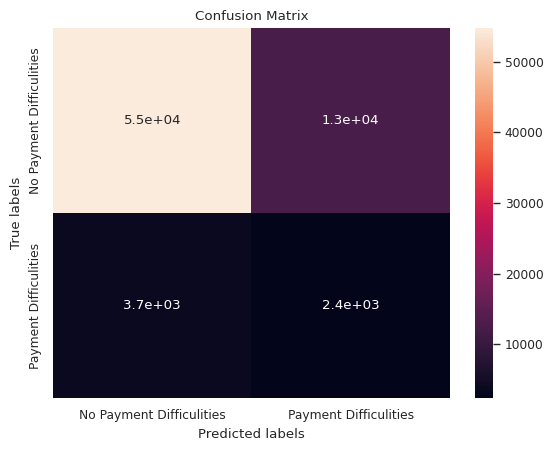

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(y_test_ohe, model_predict)

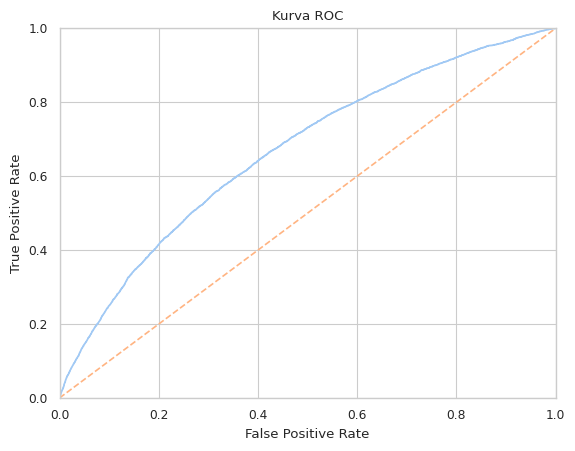

In [ ]:
# plot the ROC curve
plot_roc_auc(model_lr, X_test_ohe, y_test_ohe)

## Random Forest Classifier

In [ ]:
# define hyperparameters to tune
grid_rf = {
    "criterion" : ["gini", "entropy"],
    "n_estimators" : [10, 25],
    "max_depth" : [2, 4],
    "min_samples_leaf" : [2, 4]
}

# define the model
rf_clf = RandomForestClassifier(random_state = 42)
# define the grid search
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid = grid_rf, cv=5, scoring = 'roc_auc')
# execute search
rf_cv = grid_search_rf.fit(X_train_ohe_upsample, y_train_ohe_upsample)
# summarize result
print('The best hyperparameters are: {}'.format(rf_cv.best_params_))

The best hyperparameters are: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 25}


In [ ]:
model_rf = RandomForestClassifier(**grid_search_rf.best_params_)
model_rf.fit(X_train_ohe_upsample, y_train_ohe_upsample)
predict_rf = model_rf.predict(X_test_ohe)

In [ ]:
print_model_evaluation(y_test_ohe, predict_rf)

F1 score:  0.116
Accuracy Score:  89.59%
Precision:  0.195
Recall:  0.083
Balanced Accuracy Score:  52.59%
AUC-ROC Score:  52.59%

Confusion Matrix
--------------------------------------------------
[[65228  2074]
 [ 5566   501]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     67302
           1       0.19      0.08      0.12      6067

    accuracy                           0.90     73369
   macro avg       0.56      0.53      0.53     73369
weighted avg       0.86      0.90      0.88     73369




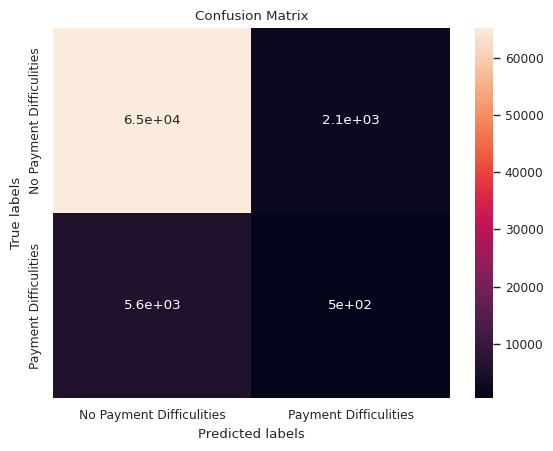

In [ ]:
plot_confusion_matrix(y_test_ohe, predict_rf)

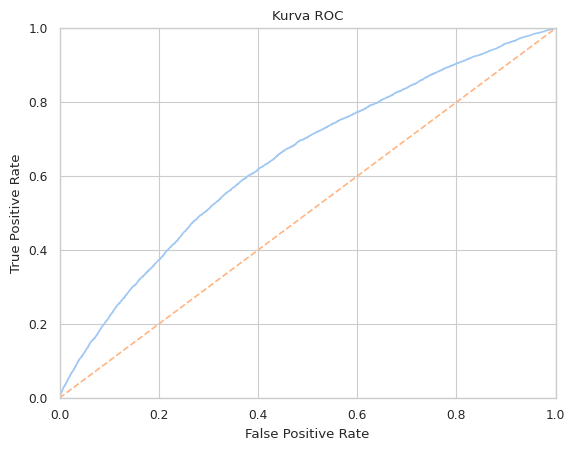

In [ ]:
plot_roc_auc(model_rf, X_test_ohe, y_test_ohe)

Text(0.5, 0, 'Random Forest Classifier Feature Importance')

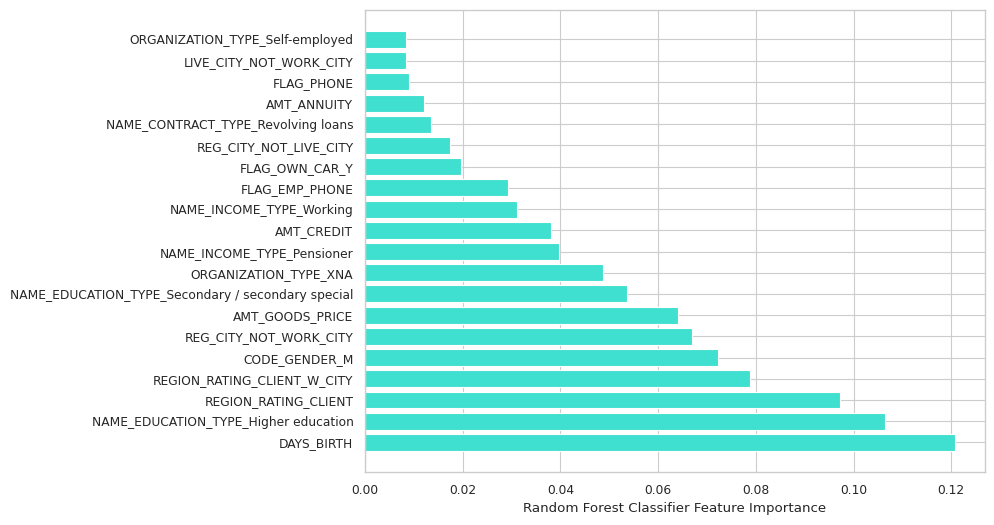

In [ ]:
sorted_feature_importance = model_rf.feature_importances_.argsort()[::-1]
plt.figure(figsize=(8,6))
plt.barh(X_train_ohe_upsample.columns[sorted_feature_importance][:20], model_rf.feature_importances_[sorted_feature_importance][:20], color='turquoise')
plt.xlabel("Random Forest Classifier Feature Importance")

## CatBoost Classifier

In [ ]:
# get categories
obj_columns = [col for col in X_train_labeled_upsample.columns if X_train_labeled_upsample[col].dtype in ['object']]
# define hyperparameters to tune
grid_cb = {'learning_rate': [0.001, 0.01],
        'depth': [4, 6],
        'l2_leaf_reg': [3, 5]
       }
# define the model
cb_clf = CatBoostClassifier(
    iterations=200,
    cat_features = obj_columns,
    logging_level = 'Silent',
    eval_metric='AUC',
    early_stopping_rounds = 50,
    random_state = 42)
# define the grid search
grid_search_cb = GridSearchCV(estimator = cb_clf, param_grid = grid_cb, scoring="roc_auc", cv=5)
# execute search
cb_cv = grid_search_cb.fit(X_train_labeled_upsample, y_train_upsample)
# summarize result
print('The best hyperparameters are: {}'.format(cb_cv.best_params_))

The best hyperparameters are: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.01}


In [ ]:
model_cbc = CatBoostClassifier(**grid_search_cb.best_params_)
model_cbc.fit(X_train_labeled_upsample, y_train_upsample, cat_features = obj_columns, eval_set=(X_train_labeled_upsample, y_train_upsample), verbose=False, plot=False)
predict_cbc = model_cbc.predict(X_test_labeled)

In [ ]:
print_model_evaluation(y_test, predict_cbc)

F1 score:  0.237
Accuracy Score:  79.38%
Precision:  0.171
Recall:  0.387
Balanced Accuracy Score:  60.89%
AUC-ROC Score:  60.89%

Confusion Matrix
--------------------------------------------------
[[55887 11415]
 [ 3717  2350]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     67302
           1       0.17      0.39      0.24      6067

    accuracy                           0.79     73369
   macro avg       0.55      0.61      0.56     73369
weighted avg       0.87      0.79      0.83     73369




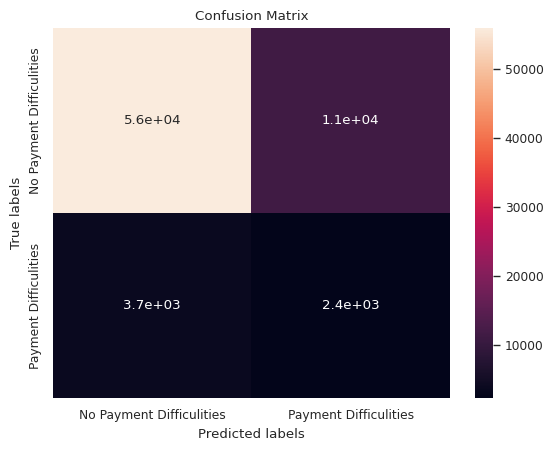

In [ ]:
plot_confusion_matrix(y_test, predict_cbc)

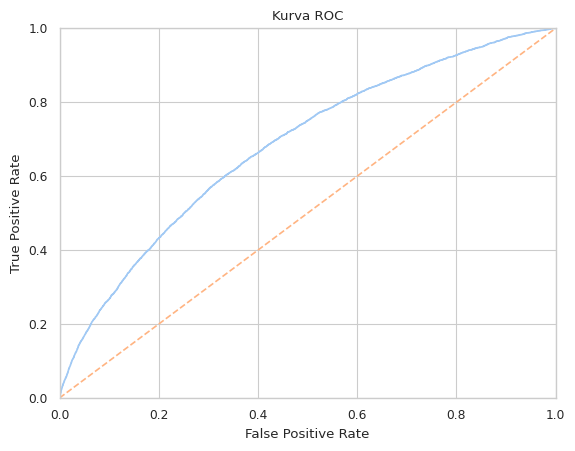

In [ ]:
plot_roc_auc(model_cbc, X_test_labeled, y_test)

Text(0.5, 0, 'CatBoost Feature Importance')

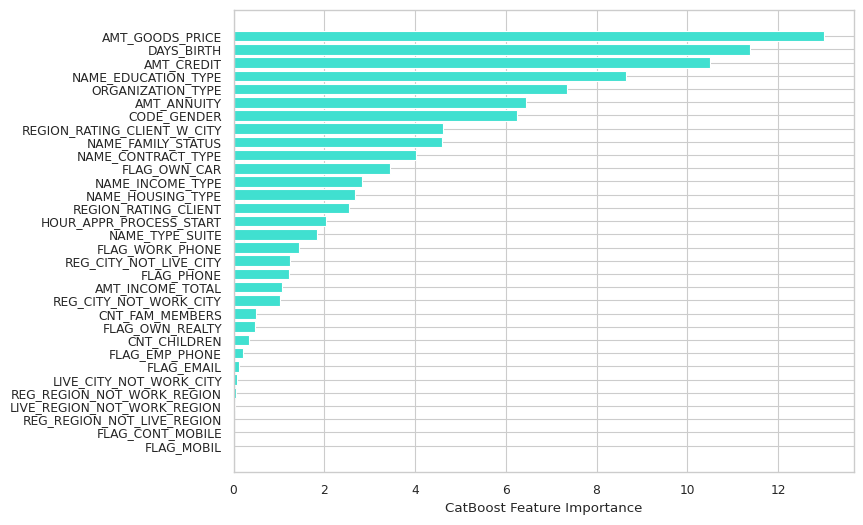

In [ ]:
sorted_feature_importance = model_cbc.feature_importances_.argsort()
plt.figure(figsize=(8,6))
plt.barh(X_train_labeled_upsample.columns[sorted_feature_importance], model_cbc.feature_importances_[sorted_feature_importance], color='turquoise')
plt.xlabel("CatBoost Feature Importance")

# Conclusion

We tuned, trained and made predictions using six models. Even we use boosting model, the best model is Random Forest Classifier with 89% accuracy.

A summary of models, their respective AUC-ROC and accuracy score. AUC-ROC score shows not that good because the data is mostly filled by 0 class. But the accuracy is pretty high arounf 89%. So, for the testing we use Random Forest Classifier model.

# Overall Conclusion

We looked into the general information about the dataset. We checked for missing values and duplicates. We observed that there are missing values. We drop some columns with large missing values and fill the missing values with median and mode. We carried out EDA and found on that:

* There were many clients who had not payment difficulties than they who did.
* The highest average for family status is married with 623512.6 and the last is widow with 480251.0.
* Client who live in appartment, had the highest average of amount credit loan.
* The highest client's amount was working type. But, they had no payment difficulities.
* Based on how many clients in every top 5 organizations, there was no one of them had payment difficulities.

Based on the observation, the action should we take is:

People living in apartments are given many loans. And most of them are working people who have the largest number of people taking out loans but they don't have payment difficulties. So you could consider creating more campaigns so that working people are more interested.

We split the data into 75% training and 25% testing sets. We used AUC-ROC as our primary metric and accuracy as the secondary metric to predict clients with no payment difficulities. We apply encoding different kind of encoding based on the algorithm to be used. We scale the data by applying standard scaler function to the features. we check class imbalance and used upsampling technique to remove imbalance in the data. We trained different model and applied hyperparameter tuning to tune different models. We choose the best model based on AUC-ROC metric score. The best model is Random Forest Classifier with accuracy 89% but the problem is AUC-ROC because the 0 class is too large.

**Evaluation:**
- Use different type of boosing model like XGBoost and LGBM classifier.
- Apply label encoding for whole categorical dataset.
- Use oversampling SMOTE.